In [2]:
import pandas as pd
import json
from matplotlib import pyplot as plt
from glob import glob

# Read all raw JSON data to Pandas Dataframe
Read JSON from `output/` directory, to download data use `download_data.py` scripts.  
Currently, for ease of processing I ignore the day with incomplete data.

In [3]:
filelist = glob('output/*.json')
all_product_power = []
all_use_power = []
all_self_use_power = []
all_date = []

for filepath in filelist:
    # Load the JSON data from a file
    with open(filepath, 'r') as file:
        data = json.load(file)
        product_power = data['data']['productPower']
        use_power = data['data']['usePower']
        self_use_power = data['data']['selfUsePower']
        date = data['data']['xAxis']
        if '--' in product_power or '--' in use_power or '--' in self_use_power:
            continue
        all_product_power += product_power
        all_use_power += use_power
        all_self_use_power += self_use_power
        all_date += date

# Create a DataFrame
df = pd.DataFrame({
    'productPower': pd.to_numeric(all_product_power),
    'usePower': pd.to_numeric(all_use_power),
    'selfUsePower': pd.to_numeric(all_self_use_power)
}, index=pd.to_datetime(all_date))

df = df.sort_index()
df

,productPower,usePower,selfUsePower
2024-05-01 00:00:00,0.0,0.208,0.0
2024-05-01 00:05:00,0.0,0.104,0.0
2024-05-01 00:10:00,0.0,0.105,0.0
2024-05-01 00:15:00,0.0,0.105,0.0
2024-05-01 00:20:00,0.0,0.104,0.0
...,...,...,...
2025-08-12 23:35:00,0.0,1.410,0.0
2025-08-12 23:40:00,0.0,2.861,0.0
2025-08-12 23:45:00,0.0,1.268,0.0
2025-08-12 23:50:00,0.0,0.916,0.0


In [4]:
# Select only interested time range
df = df[df.index > '2025-02-14']
df.head()

,productPower,usePower,selfUsePower
2025-02-14 00:05:00,0.0,0.821,0.0
2025-02-14 00:10:00,0.0,1.815,0.0
2025-02-14 00:15:00,0.0,0.372,0.0
2025-02-14 00:20:00,0.0,1.482,0.0
2025-02-14 00:25:00,0.0,1.987,0.0


# Data Analysis
Find average leftover power

In [5]:
# Find power flowing out to the Grid
df['leftover'] = (df['productPower'] - df['usePower']).clip(lower=0)
df

/tmp/ipykernel_13968/3261629081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['leftover'] = (df['productPower'] - df['usePower']).clip(lower=0)


,productPower,usePower,selfUsePower,leftover
2025-02-14 00:05:00,0.0,0.821,0.0,0.0
2025-02-14 00:10:00,0.0,1.815,0.0,0.0
2025-02-14 00:15:00,0.0,0.372,0.0,0.0
2025-02-14 00:20:00,0.0,1.482,0.0,0.0
2025-02-14 00:25:00,0.0,1.987,0.0,0.0
...,...,...,...,...
2025-08-12 23:35:00,0.0,1.410,0.0,0.0
2025-08-12 23:40:00,0.0,2.861,0.0,0.0
2025-08-12 23:45:00,0.0,1.268,0.0,0.0
2025-08-12 23:50:00,0.0,0.916,0.0,0.0


In [6]:
avg_by_time = df.groupby(df.index.time).mean(numeric_only=True)
avg_by_time.index = pd.to_datetime(avg_by_time.index.astype('str'), format="%H:%M:%S")
avg_by_time

,productPower,usePower,selfUsePower,leftover
1900-01-01 00:00:00,0.0,1.385582,0.0,0.0
1900-01-01 00:05:00,0.0,1.369067,0.0,0.0
1900-01-01 00:10:00,0.0,1.295478,0.0,0.0
1900-01-01 00:15:00,0.0,1.390551,0.0,0.0
1900-01-01 00:20:00,0.0,1.274899,0.0,0.0
...,...,...,...,...
1900-01-01 23:35:00,0.0,1.389427,0.0,0.0
1900-01-01 23:40:00,0.0,1.433410,0.0,0.0
1900-01-01 23:45:00,0.0,1.412449,0.0,0.0
1900-01-01 23:50:00,0.0,1.462775,0.0,0.0


/tmp/ipykernel_13968/1197758045.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


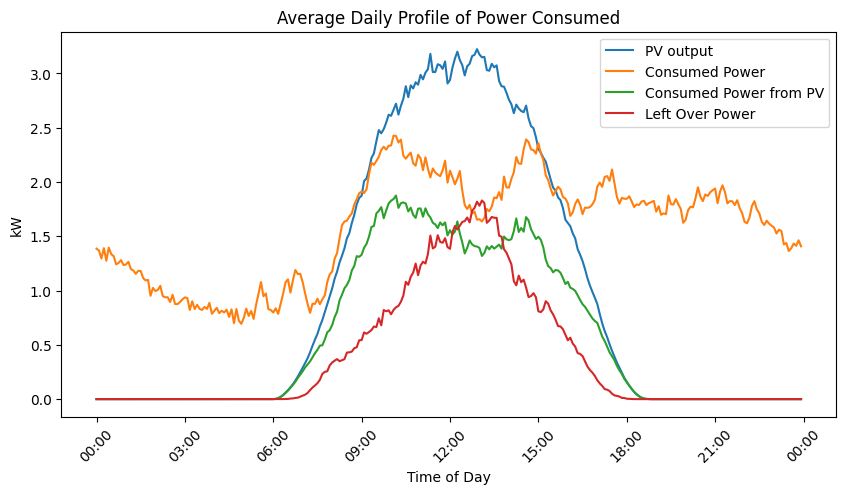

In [9]:
from matplotlib import dates as mdates

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Average Daily Profile of Power Consumed")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_xlabel("Time of Day")
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylabel("kW")

ax.plot(avg_by_time.index, avg_by_time['productPower'], label="PV output")
ax.plot(avg_by_time.index, avg_by_time['usePower'], label="Consumed Power")
ax.plot(avg_by_time.index, avg_by_time['selfUsePower'], label="Consumed Power from PV")
ax.plot(avg_by_time.index, avg_by_time['leftover'], label="Left Over Power")
ax.legend()

fig.show()

In [8]:
assert False

AssertionError: 